In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import ascii as astro_ascii
import pickle, scipy, copy, numpy as np, pandas as pd

#from alf_vars import *
from linterp import *
from scipy import constants
from velbroad import *
from set_pinit_priors import *
from setup import *
from vacairconv import *
from read_data import *
from getm2l import getm2l
from getmass import getmass
from getmodel import getmodel
from contnormspec import contnormspec
from getvelz import getvelz
from str2arr import str2arr
from spec_from_sum import spec_from_sum
from write_a_model import *
from func import *
from alf_constants import *

In [2]:
from priors import TopHat, lnprior

In [3]:
alfvar = pickle.load(open('../../alfvar_sspgrid_irldss3_imftype3.p', "rb" ))

In [4]:
pos, alfvar, mspec_ = spec_from_sum('ldss3_dr246_n4055_Re4_wave6e_imf3hernoatm', 
                                   alfvar, 
                                   getsum = 'minchi2', 
                                   returnspec=True)
mspec = mspec_[1]
posarr = str2arr(switch=1, instr=pos)

In [5]:
        alfvar.filename = 'ldss3_dr246_n4055_Re4_wave6e'
        alfvar = read_data(alfvar)
        # ---- read in the SSPs and bandpass filters
        #alfvar = setup(alfvar)
        lam = np.copy(alfvar.sspgrid.lam)

        # ---- interpolate the sky emission model onto the observed wavelength grid
        if alfvar.observed_frame == 1:
            alfvar.data.sky = linterp(alfvar.lsky, alfvar.fsky, alfvar.data.lam)
            alfvar.data.sky[alfvar.data.sky<0] = 0.                               
        else:
            alfvar.data.sky[:] = tiny_number
        alfvar.data.sky[:] = tiny_number

        # ---- we only compute things up to 500A beyond the input fit region
        alfvar.nl_fit = min(max(locate(lam, alfvar.l2[-1]+500.0),0),alfvar.nl-1)

        #define the log wavelength grid used in velbroad.f90
        alfvar.dlstep = (np.log(alfvar.sspgrid.lam[alfvar.nl_fit])-
                         np.log(alfvar.sspgrid.lam[0]))/alfvar.nl_fit
        
        for i in range(alfvar.nl_fit):
            alfvar.lnlam[i] = i*alfvar.dlstep + np.log(alfvar.sspgrid.lam[0])

        # ---- masked regions have wgt=0.0.  We'll use wgt as a pseudo-error
        # ---- array in contnormspec, so turn these into large numbers
        alfvar.data.wgt = 1./(alfvar.data.wgt+tiny_number)
        alfvar.data.wgt[alfvar.data.wgt>huge_number] = huge_number
        # ---- fold the masked regions into the errors
        alfvar.data.err = alfvar.data.err * alfvar.data.wgt
        alfvar.data.err[alfvar.data.err>huge_number] = huge_number

In [6]:
    # ---- set initial params, step sizes, and prior ranges
    opos,prlo,prhi = set_pinit_priors(alfvar)
    # ---- convert the structures into their equivalent arrays
    prloarr = str2arr(switch=1, instr = prlo)
    prhiarr = str2arr(switch=1, instr = prhi)
    
    velz = getvelz(alfvar)
    opos.velz = velz
    oposarr = str2arr(switch=1, instr=opos)

In [7]:
global global_alfvar, global_prloarr, global_prhiarr
global_alfvar = copy.deepcopy(alfvar)
global_prloarr = copy.deepcopy(prloarr)
global_prhiarr = copy.deepcopy(prhiarr)

In [8]:
key_list = ['velz', 'sigma', 'logage', 'zh', 'feh', 
                'ah', 'ch', 'nh','nah','mgh','sih','kh','cah','tih',
                'vh','crh','mnh','coh','nih','cuh','srh','bah','euh',
                'teff','imf1','imf2','logfy','sigma2','velz2',
                'logm7g','hotteff','loghot','fy_logage',
                'logemline_h','logemline_oii','logemline_oiii',
                'logemline_sii','logemline_ni','logemline_nii',
                'logtrans','jitter','logsky', 'imf3','imf4','h3','h4']

In [9]:
global use_keys
use_keys = ['velz', 'sigma', 'logage', 'zh',]

def log_prob(posarr):
    return -0.5*func(global_alfvar, posarr, 
                     prhiarr=global_prhiarr, 
                     prloarr=global_prloarr, 
                     usekeys=use_keys)

In [10]:
nwalkers = 128
npar = len(use_keys)
pos_emcee_in = np.empty((nwalkers, npar))
pos_emcee_in[:,:2] = oposarr[:2] + 10.0*(2.*np.random.rand(nwalkers, npar)[:,:2]-1.0)
pos_emcee_in[:,2:npar] = oposarr[2:npar] +  0.1*(2.*np.random.rand(nwalkers, npar)[:,2:npar]-1.0)

In [11]:
key_list = ['velz', 'sigma', 'logage', 'zh', 'feh', 
            'ah', 'ch', 'nh','nah','mgh','sih','kh','cah','tih',
            'vh','crh','mnh','coh','nih','cuh','srh','bah','euh',
                'teff','imf1','imf2','logfy','sigma2','velz2',
                'logm7g','hotteff','loghot','fy_logage',
                'logemline_h','logemline_oii','logemline_oiii',
                'logemline_sii','logemline_ni','logemline_nii',
                'logtrans','jitter','logsky', 'imf3','imf4','h3','h4']

default_arr = np.array([0.0, 11.0, 1.0, 0.0, 0.0,0.0,0.0,0.0, 0.0, 0.0,  
                        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                        0.0, 0.0, 0.0, 0.0, 0.0, 1.3, 2.3, -4.0, 
                        11.0, 0.0, -4.0, 20.0, -4.0, 0.3, 
                        -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, 
                        -4.0, 1.0, -4.0, 0.10, 0.0, 0.0, 0.0])
key_arr = np.array(key_list)

In [12]:
func(global_alfvar,pos_emcee_in[0,:], prhiarr=global_prhiarr, 
     prloarr=global_prloarr,usekeys = use_keys)

98498.43528811494

In [ ]:
import emcee, time
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, npar, log_prob, pool=pool)
    start = time.time()
    state = sampler.run_mcmc(pos_emcee_in, 100, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))  

In [11]:
import matplotlib.pyplot as plt
samples = sampler.get_chain()

NameError: name 'sampler' is not defined

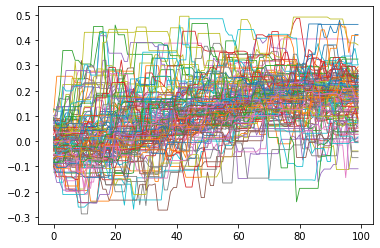

In [24]:
for i in range(samples.shape[1]):
    plt.plot(samples[:,i,8], lw=0.8)
#plt.ylim(3e3, 1e4)

In [ ]:
import cProfile
cProfile.run("func(alfvar, posarr)")

In [13]:
log_prob(posarr), log_prob(oposarr)

(-28961.565416724843, -40713.36541615539)

In [12]:
global use_keys
use_keys = ['velz', 'sigma', 'logage', 'zh',]

def log_prob(posarr):
    ln_prior = lnprior(posarr, usekeys = use_keys, 
                       prhiarr=global_prhiarr, prloarr=global_prloarr, 
                       nested = True)
    if not np.isfinite(ln_prior):
        return -np.infty
    
    return ln_prior - 0.5*func(global_alfvar, posarr, 
                     prhiarr=global_prhiarr, 
                     prloarr=global_prloarr, 
                     usekeys=use_keys)

In [13]:
import dynesty
from dynesty import NestedSampler, DynamicNestedSampler

In [14]:
def prior_transform(unit_coords, usekeys = use_keys,
                    prhiarr=global_prhiarr, prloarr=global_prloarr):    
    theta = np.empty((len(unit_coords)))
    key_arr = np.array(['velz', 'sigma', 'logage', 'zh', 'feh', 
            'ah', 'ch', 'nh','nah','mgh','sih','kh','cah','tih',
            'vh','crh','mnh','coh','nih','cuh','srh','bah','euh',
                'teff','imf1','imf2','logfy','sigma2','velz2',
                'logm7g','hotteff','loghot','fy_logage',
                'logemline_h','logemline_oii','logemline_oiii',
                'logemline_sii','logemline_ni','logemline_nii',
                'logtrans','jitter','logsky', 'imf3','imf4','h3','h4'])
    
    for i, ikey in enumerate(usekeys):
        ind = np.where(key_arr==ikey)
        a = TopHat(prloarr[ind].item(), prhiarr[ind].item())
        theta[i] = a.unit_transform(unit_coords[i])
    return theta

In [71]:
dsampler = dynesty.DynamicNestedSampler(log_prob, prior_transform, 
                                        len(use_keys), nlive=1000)
dsampler.run_nested(maxiter = 1000)

1501it [17:09,  1.46it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 3531 | eff(%): 42.509 | loglstar:   -inf < -32967.273 <    inf | logz: -32976.182 +/-  0.197 | dlogz:  1.099 >  0.010]    


In [72]:
res1 = dsampler.results

In [79]:
import pickle

In [81]:
pickle.dump(res1, open('../test_dynesty_res.p', "wb" ) )

In [82]:
res1

         niter: 1501
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 42.50920419144718
       samples: array([[3.87051199e+04, 1.07613080e+02, 1.13665310e+00, 2.70723063e-01],
       [1.18110096e+04, 1.73253934e+01, 1.06268868e+00, 2.18972338e-01],
       [2.20204242e+04, 5.95913475e+01, 1.02972300e+00, 2.32715523e-01],
       ...,
       [7.08194388e+03, 4.45303181e+02, 5.74312501e-01, 2.39962409e-01],
       [7.22563858e+03, 4.72910492e+02, 6.51788434e-01, 6.18580475e-03],
       [7.23155305e+03, 3.98562625e+02, 1.11438974e+00, 2.45682703e-01]])
    samples_id: array([  5, 298, 119, ..., 456, 243, 499])
 samples_batch: array([0, 0, 0, ..., 0, 0, 0])
    samples_it: array([  0,   0,   0, ..., 693, 998, 773])
     samples_u: array([[0.77853176, 0.09859907, 0.9858373 , 0.9860586 ],
       [0.25119627, 0.00739939, 0.87527876, 0.9614154 ],
       [0.45138087, 0.05009227, 0.82600321, 0.96795977],
       ...,
       [0.15846949, 0.43970018, 0.14527692, 0.97141067],
       [0.

In [74]:
samples = res1.samples

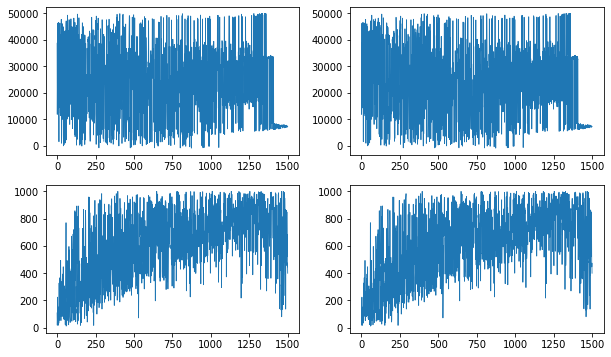

In [75]:
fig, axl = plt.subplots(2, 2, figsize=(10, 6))
for i in range(2):
    for j in range(2):
       axl[i][j].plot(samples[:,i], lw=0.8)
#plt.ylim(3e3, 1e4)

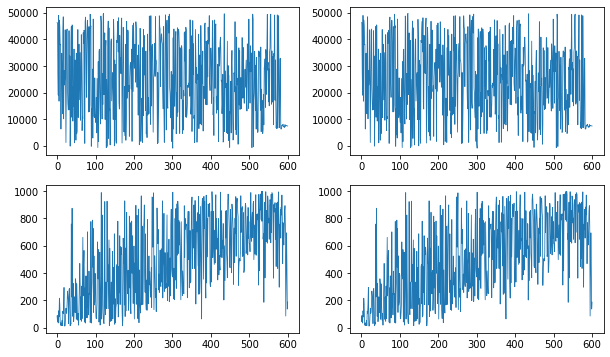

In [62]:
fig, axl = plt.subplots(2, 2, figsize=(10, 6))
for i in range(2):
    for j in range(2):
       axl[i][j].plot(samples[:,i], lw=0.8)
#plt.ylim(3e3, 1e4)